# Trying to predict raw MBTI type

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandasql as sql

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.semi_supervised import SelfTrainingClassifier
from pandasql import sqldf
from sklearn.base import BaseEstimator, TransformerMixin
import Levenshtein

In [3]:
db_f_activities = pd.read_pickle('db_exploitable.pkl')
display(db_f_activities)

,report_title,channels,hand_preference,mbti_type,analysis_version,frequency_bandwidths,executive_style,top_patterns,top_skills,average_circuit_hits_decision_making,...,average_circuit_hits_abstract,average_circuit_hits_concrete,average_circuit_hits_social,average_circuit_hits_technical,region_hits_circuit_hits,region_hits_regions,top_circuit_hits_hits,top_circuit_hits_circuits,top_patterns_encoded,top_skills_cleaned
0,10 Daily Activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",RIGHT,INTP,2001-02-01 00:00:00,"[""0.5:45""]",ENERGIZER,"[""STRONG_STARBURST"",""LEFT"",""CENTER_BACK""]","[""O1"",""PO7"",""P8"",""O2"",""CP6"",""PO8""]",53371,...,55753.57,56380,55519.168,55362.168,"[57007,57152,56292,56591,57018,56339,56678,569...","[""C3"",""CP1"",""O1"",""O2"",""P4"",""PO8"",""C4"",""CP2"",""C...","[4585,1277,982,918,748,616,605,595,564,549,473...","[""C3:C4:CP1:CP2:CP5:CP6:CZ:F3:F4:F7:F8:FC1:FC2...",CB LL SU,CP6 O1 O2 P8 PO7 PO8
1,Daily activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",LEFT,None,2001-02-01 00:00:00,"[""0.5:45""]",ENERGIZER,"[""STRONG_STARBURST"",""LEFT"",""HALO""]","[""O1"",""PO7"",""P7"",""FT9"",""T7"",""O2""]",49629,...,54468.57,56234.855,55770,57082.832,"[53913,54661,49629,51002,55692,56936,57481,567...","[""F4"",""F8"",""FP1"",""FPZ"",""O1"",""P4"",""PO7"",""PO8"",""...","[1561,694,685,647,624,574,539,519,511,492,485,...","[""O1:PO7"",""O1:P7:PO7"",""FT10:FT9"",""P7:T7"",""P7:P...",HH LL SU,FT9 O1 O2 P7 PO7 T7
2,9 daily activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",RIGHT,INTP,2001-02-01 00:00:00,"[""0.5:45""]",REFINER,"[""CENTER_FRONT"",""CENTER_BACK"",""RIGHT""]","[""T8"",""PO8"",""P8"",""P7"",""O2"",""T7""]",37356,...,47302.715,47486.285,47424.5,48528.668,"[47755,48280,47823,50311,46119,37356,49120,494...","[""C4"",""CZ"",""FC2"",""P4"",""F8"",""FP1"",""O1"",""PO7"",""P...","[1689,640,630,552,547,531,512,509,493,475,464,...","[""O2:PO8"",""CP6:P8"",""P8:PO8"",""CP5:P7"",""FC6:T8"",...",CB CF RR,O2 P7 P8 PO8 T7 T8
3,10 daily activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",RIGHT,None,2001-02-01 00:00:00,"[""0.5:45""]",REFINER,"[""BACK"",""LEFT"",""CENTER_BACK""]","[""P7"",""PO7"",""P8"",""PO8"",""O1"",""FT9""]",35679,...,36529.57,36580.855,36142,36649.332,"[37513,36812,37166,36201,36236,31689,33415,363...","[""C4"",""FC2"",""P4"",""FT9"",""O1"",""P7"",""P8"",""PO7"",""C...","[2658,1991,1641,1106,1075,682,513,508,504,504,...","[""P7:PO7"",""P8:PO8"",""O1:PO7"",""O1:P7:PO7"",""P7:P8...",BB CB LL,FT9 O1 P7 P8 PO7 PO8
4,10 Daily Activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",RIGHT,INFJ,2001-02-01 00:00:00,"[""0.5:45""]",REFINER,"[""BACK"",""HALO"",""HIDDEN_STARBURST""]","[""O1"",""PO7"",""O2"",""PO8"",""P7"",""FT9""]",69148,...,72367.86,73119.14,70975.164,72367.836,"[71292,68829,74352,72801,74012,73500,67784,731...","[""F7"",""O2"",""CP6"",""F3"",""FC1"",""FC5"",""FT9"",""FZ"",""...","[3680,1801,1665,1300,1041,861,776,707,668,650,...","[""O1:PO7"",""O2:PO8"",""O1:O2"",""P7:PO7"",""O1:P7:PO7...",BB DU HH,FT9 O1 O2 P7 PO7 PO8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,10 Daily Activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",RIGHT,ENFP,2001-02-01 00:00:00,"[""0.5:45""]",ENERGIZER,"[""STRONG_STARBURST"",""RANDOM_FIELD"",""AUDIO_KINE...","[""T7"",""T8"",""O2"",""FT9"",""P7"",""PO8""]",47347,...,49532.715,50133.145,48627.832,48541.168,"[49553,49877,49585,49912,51480,50945,50830,495...","[""CP2"",""CZ"",""FC2"",""C4"",""CP5"",""CP6"",""FC5"",""FT10...","[1531,1226,1064,736,680,672,648,610,565,550,51...","[""T7:T8"",""FT9:T7"",""O2:PO8"",""O2:T7"",""O2:T8"",""CP...",AK NN SU,FT9 O2 P7 PO8 T7 T8
123,10 Daily Activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",RIGHT,INTJ,2001-02-01 00:00:00,"[""0.5:45""]",REFINER,"[""LEFT"",""HALO"",""CENTER_FRONT""]","[""FT9"","

In [4]:
# Step 1: Clean text columns
def clean_text_column(col):
    return col.apply(lambda x: ' '.join(x) if isinstance(x, list) else (str(x) if x is not None else '')).replace('', 'unknown')

db_f_activities['top_patterns_encoded'] = clean_text_column(db_f_activities['top_patterns_encoded'])
db_f_activities['top_skills_cleaned'] = clean_text_column(db_f_activities['top_skills_cleaned'])

# Step 2: Fix corrupted numeric columns (e.g., strings/dates in numeric columns)
# Convert to numeric safely
numeric_cols = [
    'average_circuit_hits_decision_making', 'average_circuit_hits_perception',
    'average_circuit_hits_abstract', 'average_circuit_hits_concrete',
    'average_circuit_hits_social', 'average_circuit_hits_technical'
]

for col in numeric_cols:
    db_f_activities[col] = pd.to_numeric(db_f_activities[col], errors='coerce')

# Step 3: Remove rows with NaN in any of the numeric columns
query = """
SELECT average_circuit_hits_abstract, 
    average_circuit_hits_concrete,
    average_circuit_hits_social,
    average_circuit_hits_technical,
    average_circuit_hits_decision_making,
    average_circuit_hits_perception,
    top_patterns_encoded, 
    top_skills_cleaned, 
    mbti_type
FROM db_f_activities
WHERE 
    average_circuit_hits_abstract IS NOT NULL AND
    average_circuit_hits_concrete IS NOT NULL AND
    average_circuit_hits_social IS NOT NULL AND
    average_circuit_hits_technical IS NOT NULL AND
    average_circuit_hits_decision_making IS NOT NULL AND
    average_circuit_hits_perception IS NOT NULL
"""
db_f_activities_clean = sqldf(query)

In [5]:
# Step 4: Separate labeled and unlabeled
labeled_df = db_f_activities_clean[db_f_activities_clean['mbti_type'].notnull()]
unlabeled_df = db_f_activities_clean[db_f_activities_clean['mbti_type'].isnull()]

# Step 5: Define preprocessing pipelines
text_pipeline = TfidfVectorizer()
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())


In [6]:
# --- Custom Levenshtein distance transformer ---
class LevenshteinVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, reference=None):
        self.reference = reference

    def fit(self, X, y=None):
        self.reference = pd.Series(X.values.ravel()).dropna().unique().tolist()
        return self

    def transform(self, X):
        return np.array([
            [Levenshtein.distance(str(x), str(ref)) for ref in self.reference]
            for x in X.values.ravel()
        ])

Classification Report :
              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00         5
        ENFP       0.29      0.22      0.25         9
        ENTJ       0.33      0.29      0.31         7
        ENTP       0.00      0.00      0.00         5
        ESFJ       0.00      0.00      0.00         2
        ESFP       0.00      0.00      0.00         2
        ESTJ       0.00      0.00      0.00         5
        ESTP       0.00      0.00      0.00         4
        INFJ       0.18      0.33      0.24        12
        INFP       0.00      0.00      0.00         4
        INTJ       0.00      0.00      0.00         8
        INTP       0.00      0.00      0.00         9
        ISFJ       0.00      0.00      0.00         1
        ISFP       0.00      0.00      0.00         1
        ISTJ       0.30      0.60      0.40         5
        ISTP       0.25      0.33      0.29         3

    accuracy                           0.15        82
  

/Users/julesponce/opt/anaconda3/envs/Finance-QL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/julesponce/opt/anaconda3/envs/Finance-QL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/julesponce/opt/anaconda3/envs/Finance-QL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

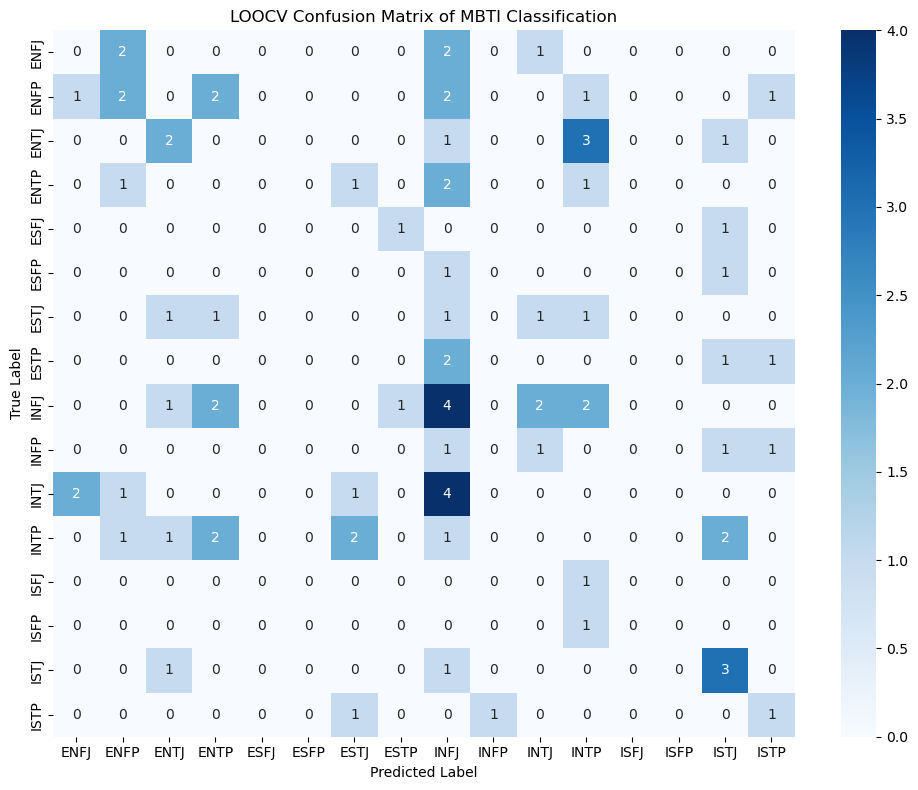

In [10]:
import seaborn as sns
# --- Features and labels ---
X = labeled_df.drop(columns=['mbti_type'])
y = labeled_df['mbti_type']
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

# --- Preprocessing ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('patterns_lev', Pipeline([
            ('lev', LevenshteinVectorizer())
        ]), 'top_patterns_encoded'),
        ('skills_lev', Pipeline([
            ('lev', LevenshteinVectorizer())
        ]), 'top_skills_cleaned'),
    ],
    remainder='drop'
)

# --- Classifier pipeline ---
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# --- Leave-One-Out CV ---
loo = LeaveOneOut()
y_true, y_pred = [], []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf_pipeline.fit(X_train, y_train)
    pred = clf_pipeline.predict(X_test)
    
    y_true.append(y_test.values[0])
    y_pred.append(pred[0])

# --- Evaluation ---
print("Classification Report :")
print(classification_report(y_true, y_pred))

print("Confusion Matrix :")
print(confusion_matrix(y_true, y_pred))

# Confusion matrix
X_labeled = preprocessor.fit_transform(labeled_df)
y_labeled = labeled_df['mbti_type'].values
labels = np.unique(y_labeled)
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('LOOCV Confusion Matrix of MBTI Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()